<a id="tercero"></a>
## 2. *Transfer Learning*

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/05/31130754/transfer-learning.jpeg"/>

En esta sección se trabajará con el dataset trabajado anteriormente, CIFAR [3], pero en su versión más fina, en el cual se presentan 100 tipos distintos de categorías a clasificar la imagen (mutuamente excluyente), no 10 como se usó en las actividades anteriores. La estructura es la misma, son 60000 imágenes RGB de 32 $\times$ 32 píxeles separados en 50 mil de entrenamiento y 10 mil de pruebas.  
Aquí se experimentará con el concepto de *transfer learning* el cual consta en transferir conocimiento de un dominio fuente (*source domain*) a un dominio objetivo (*target domain*). En redes neuronales existen muchas representaciones de esto, en común consta en pre inicializar los pesos de la red de alguna manera que no sea con distribuciones de manera aleatoria (*fine tunning*). También está lo que es utilizar una representación generada a través de otra red entrenada con muchos datos, esto es tomar la red y "*congelar*" sus primeras capas para tomar esta representación y no entrenar esos pesos, lo que realizaremos en esta sección. 



## a) 
Entrene una red neuronal convolucional como se presenta en el código a continuación durante 15 epochs, realizando un gráfico de evolución de la función de pérdida y de la exactitud del algoritmo (accuracy) sobre ambos conjuntos, entrenamiento y pruebas. Comente sobre el tiempo de ejecución de este entrenamiento. Reporte el accuracy del modelo final sobre el conjunto de pruebas.

In [57]:
import keras
import matplotlib.pyplot as plt
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.optimizers import SGD
import numpy as np

In [58]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [59]:
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)
x_train_norm = x_train/255.0
x_test_norm = x_test/255.0

### Modelo construido:

In [29]:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam')

optimizer = SGD(lr=0.01,momentum=0.9) 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
#model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

Debido a la gran cantidad de parámetros entrenables del modelo, se espera que el entrenamiento sea lento en CPU. Como se verá en los tiempos computacionales, afortunadamente, el utilizar GPU remedia la situación debido a la alta capacidad de paralelismo del modelo.

In [20]:
metrics = np.loadtxt('part2code/part2models/a_metrics.txt')
acc = metrics[0,:]
loss = metrics[1,:]
val_acc = metrics[2,:]
val_loss = metrics[3,:]

### Gráficos de error y accuracy

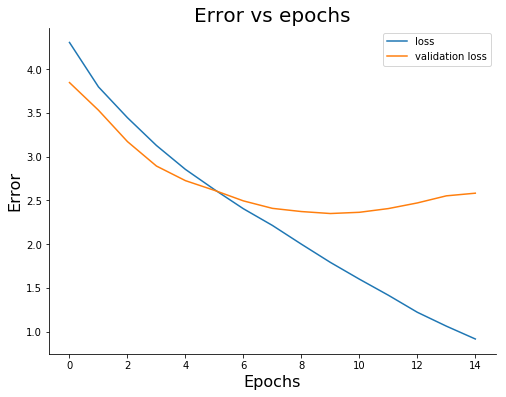

In [43]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)

plt.plot(loss,label='loss')
plt.plot(val_loss,label='validation loss')

plt.title('Error vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Error", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Se observa en este gráfico que, después de aproximadamente 10 epochs, la pérdida sobre el conjunto de validación empieza a aumentar, lo cual es un comportamiento indeseable. Esto se puede remediar, posiblemente, con la utilización de algún regularizador que evite que el modelo haga overfitting. Que la pérdida aumente es una mala señal, sin embargo, no implica que la accuracy también disminuya: debido a que la función cross-entropy trata de maximizar la probabilidad de las clases, la pérdida puede disminuir al asignarle menos probabilidad a la clase correcta, pero la accuracy se mantendrá igual si la probabilidad no cruza el umbral del 50%. En el gráfico de accuracy se observa este fenómeno.

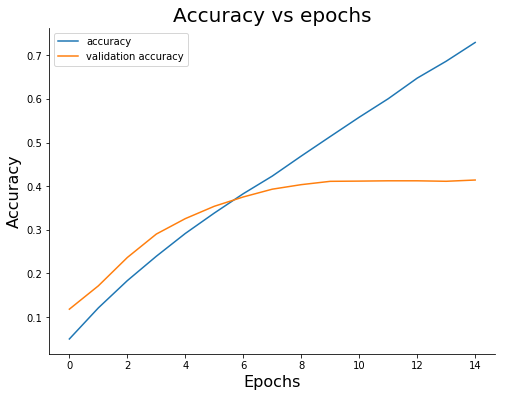

In [45]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)


plt.plot(acc,label='accuracy')
plt.plot(val_acc,label='validation accuracy')

plt.title('Accuracy vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Tal como se mencionó anteriormente, no necesariamente un aumento del error implica una disminución del accuracy, lo cual puede observarse en el gráfico. La accuracy se mantiene constante e incluso empieza a aumentar en cierto punto. Aún así, el hecho de  que la accuracy en la validación pareciera estancarse rápidamente mientras que la accuracy en el training aumenta es una clara señal de overfitting del modelo, ya que está "memorizando" los datos del training mientras que no mejora su capacidad de generalización, por lo que la utilización de regularizadores podría ayudar a mejorar la situación.

### Tiempos computacionales

En cuanto a tiempo computacional, primero mostramos cuánto se demora en realizarse un epoch en una potente CPU. Se observa que el tiempo está en el orden de los minutos, lo cual es problemático si se quieren realizar muchas epochs y muchos experimentos.

![title](part2code/a_tiempo_cpu.png)

Al hacer altamente paralelizables, es mejor entrenar algoritmos de redes convolucionales en GPUs, en donde los cómputos pueden realizar en paralelo en los nodos CUDA. Entrenamos nuestro modelo en una GTX1080 ti, en donde el tiempo de ejecución de un epoch disminuye al orden de los segundos, como se puede ver en la imagen a continuación

![title](part2code/a_tiempo_gpu.png)

## b) 
Debido al comportamiento de las curvas de entrenamiento, claramente se ve que se necesita un regularizador. Experimente utilizando Dropout con una tasa de 0.25 en las tandas convolucionales, elija donde situarlo, luego de la primera convolución, después de la segunda, solamente después del pooling, en todas o alguna forma que le parezca conveniente, de argumentos de ello. La idea es que se forme una idea de dónde conviene colocar el regularizador y porqué.

Haremos el experimento de utilizar dropout de 0.25 en la primera tanda convolucional. Experimentaremos con 4 escenarios distintos: utilizar dropout después de la primera convolución (dropout_1), después de la primera y segunda convolución (dropout_2), después de la primera, segunda, y luego del max pooling (dropout_3), y sólo después del pooling (dropout_pooling). Comparamos los resultados de estos modelos en el conjunto de validación, midiendo la accuracy, que como vimos anteriormente, es el indicador más fidedigno en cuanto al desempeño del modelo (ya que la loss puede aumentar sin que la accuracy disminuya).

![title](part2code/drop_models.png)

In [39]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
#model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='softmax'))
#model.summary()

### Gráfico comparación de modelos

In [45]:
metrics_b1 = np.loadtxt('part2code/part2models/b1_metrics.txt')
#acc = metrics[0,:]
#loss = metrics[1,:]
val_acc_b1 = metrics_b1[2,:]
val_loss_b1 = metrics_b1[3,:]

metrics_b2 = np.loadtxt('part2code/part2models/b2_metrics.txt')
#acc = metrics[0,:]
#loss = metrics[1,:]
val_acc_b2 = metrics_b2[2,:]
val_loss_b2 = metrics_b2[3,:]

metrics_b3 = np.loadtxt('part2code/part2models/b3_metrics.txt')
#acc = metrics[0,:]
#loss = metrics[1,:]
val_acc_b3 = metrics_b3[2,:]
val_loss_b3 = metrics_b3[3,:]

metrics_b4 = np.loadtxt('part2code/part2models/b4_metrics.txt')
acc_b4 = metrics[0,:]
#loss = metrics[1,:]
val_acc_b4 = metrics_b4[2,:]
val_loss_b4 = metrics_b4[3,:]

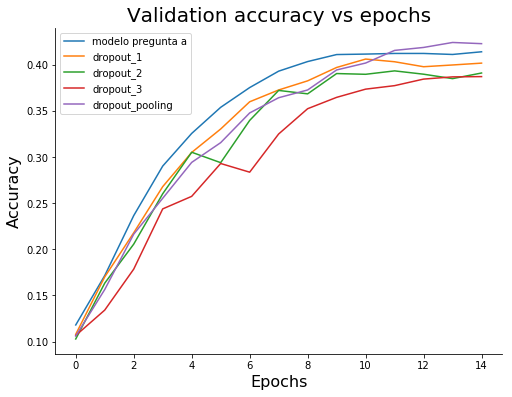

In [46]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)

plt.plot(val_acc,label='modelo pregunta a')
plt.plot(val_acc_b1,label='dropout_1')
plt.plot(val_acc_b2,label='dropout_2')
plt.plot(val_acc_b3,label='dropout_3')
plt.plot(val_acc_b4,label='dropout_pooling')

plt.title('Validation accuracy vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Se observa que el mejor resultado en cuanto a accuracy se obtiene cuando utilizamos dropout sólo después de la capa de pooling, llegando a superar al modelo de la pregunta a) luego de cierta cantidad de epochs. Conjeturamos que esto se debe a que dropout nos permite generar características que son útiles por sí mismas. Una capa convolucional seguida de una capa de pooling realizan una búsqueda de cierta característica en un vecindario de la imagen, por lo que es después del pooling cuando la característica se revela como presente o no, y son estas características las que queremos que sean independientes. Por otro lado, el aplicar dropout antes del pooling puede ser incluso inútil en muchos casos: si la característica a la que se le aplica dropout no es la máxima del vecindario, entonces dropout no tendrá ningún efecto porque de igual manera iba a ser ignorada por el max pooling. 

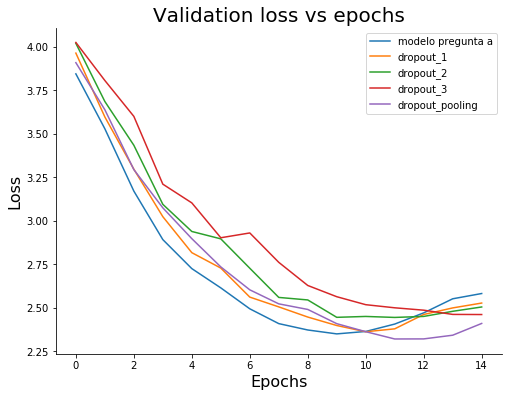

In [43]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)

plt.plot(val_loss,label='modelo pregunta a')
plt.plot(val_loss_b1,label='dropout_1')
plt.plot(val_loss_b2,label='dropout_2')
plt.plot(val_loss_b3,label='dropout_3')
plt.plot(val_loss_b4,label='dropout_pooling')

plt.title('Validation loss vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Observamos el mismo fenómeno en la pérdida, en la que ésta aumenta pero el accuracy no disminuye. Aún así, claramente la pérdida del modelo de dropout_pooling es menor que las demás en el conjunto de validación, lo cual, en este caso, se ve a su vez reflejada en la accuracy.

Finalmente, mostramos cómo se comporta la accuracy con respecto a la accuracy de validación del modelo dropout_pooling

### Accuracy y accuracy de validación en dropout_pooling

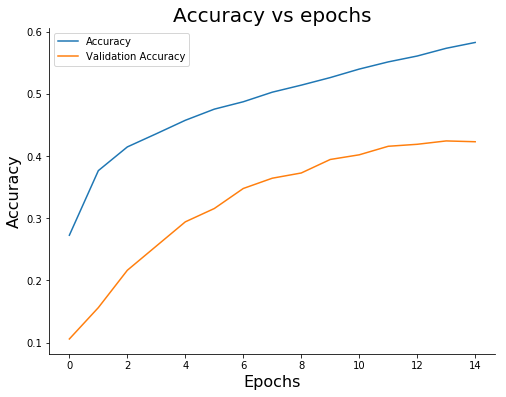

In [47]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)

plt.plot(acc_b4,label='Accuracy')

plt.plot(val_acc_b4,label='Validation Accuracy')

plt.title('Accuracy vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Se observa claramente un mejor comportamiento en cuanto a que la accuracy no aumenta tan descontroladamente como en el modelo de la pregunta a). Esto es algo deseable, ya que en la práctica no tenemos la curva de prueba y queremos que la curva de accuracy en el entrenamiento sea lo más similar a la de pruebas para poder elegir apropiadamente con qué modelo vamos a quedarnos

## c)
Una forma de hacer lo que se conoce como transfer learning es utilizar el conocimiento (los parámetros) aprendido por una red entrenada con millones de imágenes, y tomar estos parámetros como los pre entrenados. Para esto se utilizará el modelo VGG16 [7] proporcionado a través de la interfaz de keras. Visualice el modelo y sus 23 capas. Para esta instancia se utilizará todo lo aprendido por las capas convolucionales, es decir, se eliminan las capas densas del modelo y se agregan unas nuevas a ser entrenadas desde cero.
Recuerde normalizar los datos de la manera en que fue entrenado VGG ¿Cuál es éste proceso?

In [56]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Input
x_train_vgg = preprocess_input(x_train)
x_test_vgg = preprocess_input(x_test)
input_tensor=Input(shape=x_train_vgg.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor ) # LOAD PRETRAINED MODEL 
modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

La red VGG16 tiene una enorme cantidad de parámetros, lo cual nos podría impedir re-entrenarla completamente por problemas de memoria. En vez, se eliminan las capas densas y se computan las activaciones del modelo restante para ser alimentadas a un modelo nuevo. El eliminar las capas densas nos permite, además, trabajar con imágenes de un tamaño distinto al con el cual el modelo fue entrenado, ya que los parches convolucionales pueden ser aplicados independiente de la escala de la imagen, siendo las capas densas las que necesitan de una arquitectura de entrada pre-definidas. Esto, sin embargo, puede tener como consecuencia que no se extraigan características útiles, ya que los filtros convolucionales fueron diseñados especialmente para cierta escala. La red que utilizamos fue entrenada usando ImageNet, el cual es un dataset de millones de imágenes, con más de 100000 entidades del mundo real. El posible beneficio de utilizar esta red pre-entrenada es que muchas características importantes para realizar clasificación son equivalentes cuando tratamos con entidades del mundo real, tales como patrones geómetricos y agrupaciones de estos.

Para que tenga sentido utilizar este modelo pre-entrenado, se necesita que las entradas sean similares en cuanto a la escala de las características (rango 0-1 por ejemplo). Por ende, se le aplica el mismo pre-procesamiento a las imágenes que se le aplicó a las imágenes del modelo original, el cual es simplemente extraer la media de los valores de cada pixel.

## d)
Entrene esta red agregando una capa densa de 1024 neuronas seguido de un dropout de 0.5, finalmente es necesario agregar la capa de clasificación para las 100 clases. Utilice la misma configuración del optimizador para que las comparaciones sean válidas. Entrene unicamente por 10 epochs y grafique las curvas de entrenamiento con respecto al modelo definido en a) o con regularización definido en b) ¿Qué sucede? Comente.



Se construye un modelo que recibe las características del modelo convolucional anterior y aprende a clasificar las imágenes en el dominio deseado. El modelo tiene una capa densa de tamaño 1024, que intentará combinar las características entregadas por el modelo convolucional para realizar la clasificación. Se compara este modelo (vgg16) con el modelo de la pregunta a) y el modelo dropout_pooling de la pregunta b) en accuracy sobre el conjunto de validación

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
...#clasification
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=1,validation_data=(features_test,y_test))

In [53]:
metrics = np.loadtxt('part2code/part2models/c_metrics.txt')
#metrics_acc = np.loadtxt('part2code/part2models/bdrops_acc.txt')
acc = metrics[0,:]
loss = metrics[1,:]
val_acc_c = metrics[2,:]
val_loss_c = metrics[3,:]

### Gráfico de comparación de modelos sobre conjunto de validación

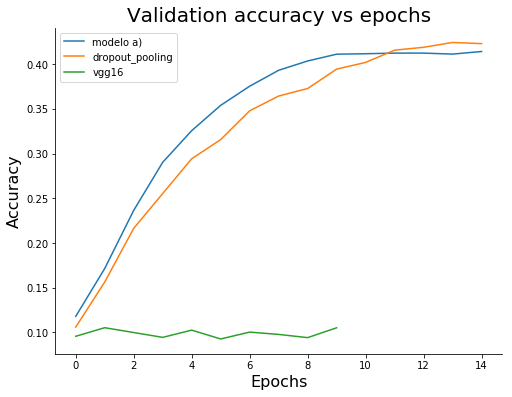

In [52]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)


#plt.plot(val_loss_b1,label='accuracy')
plt.plot(val_acc,label='modelo a)')
plt.plot(val_acc_b4,label='dropout_pooling')
plt.plot(val_acc_c,label='vgg16')

plt.title('Validation accuracy vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Comparando la accuracy en el conjunto de validación con los otros modelos, se observa que el modelo no aprende nada, permaneciendo siempre en una accuracy de un 10%. Inspeccionamos si éste es un caso de overfitting observando la accuracy de entrenamiento, la cual se muestra en el siguiente gráfico:

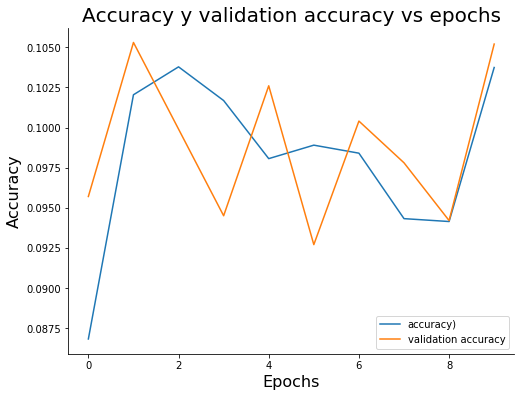

In [55]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)


#plt.plot(val_loss_b1,label='accuracy')
plt.plot(acc,label='accuracy)')

plt.plot(val_acc_c,label='validation accuracy')

plt.title('Accuracy y validation accuracy vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Es claro que estamos frente a un caso de underfitting, ya que durante el entrenamiento el modelo no logra mejorar su accuracy. Para entender qué puede estar sucediendo, observamos el promedio de la media y el promedio de la desviación estándar de las  las activaciones de las características obtenidas utilizando el modelo convolucional, a partir de una muestra de 2000 datos:

In [63]:
features_train = modelVGG.predict(x_train_vgg[:2000])
feature_train = features_train.flatten()

In [89]:
np.mean(np.mean(features_train.reshape(2000,-1),axis=0))
np.mean(np.std(features_train.reshape(2000,-1),axis=0))

10.733555

In [91]:
print("Media promedio de las activaciones: {}".format(np.mean(np.mean(features_train.reshape(2000,-1),axis=0)))) 
print("Desviación estándar promedio de las activaciones: {}".format(np.mean(np.std(features_train.reshape(2000,-1),axis=0)))) 


Media promedio de las activaciones: 3.5207786560058594
Desviación estándar promedio de las activaciones: 10.73355484008789


Con una media y desviación estándar promedios aproximadas de 3.52 y 10.73, es claro que la distribución de entrada de las activaciones no siguen el estándar de media 0 y desviación estándar 1. Es sabido que esto ocasiona problemas, debido a que las escala es muy grande con respecto al tamaño de los pesos, dificultando el entrenamiento del modelo que recibe estas características a tal punto, que este es incapaz de aprender. Por ello, una opción es normalizar las características de entrada, lo cual se puede lograr de forma manual o utilizando una capa de Batch Normalization. Lo segundo tiene ventajas por sobre lo primero, ya que la distribución de las características es más flexible (el modelo puede aprender que la media ideal es distinta de 0, por ejemplo).

## e) 
Agregue una capa de normalización (Batch Normalization [8]) de las activaciones en las capas densas, esto es, restar por la media del batch y dividir por la desviación estándar. Vuelva a entrenar el modelo con la misma configuración pero ahora por 15 epochs. Comente lo observado y compare las curvas de convergencia con los modelos anteriores ¿Por qué esto mejora a lo presentado en e)? Realice los mismos gráficos que en a) a través del número de epochs y comente sobre el tiempo de ejecución de este entrenamiento.



Como se mencionó en el punto anterior, una de las maneras con las que se puede solucionar el problema de la distribución de las entradas es utilizar Batch Normalization desde el inicio del modelo. Acá, utilizamos ese enfoque, aplicando BN a la capa que recibe las características de la red convolucional, y luego nuevamente BN después de la capa densa que debe ser entrenada. Volvemos a comparar este enfoque (vgg16_bn) con el enfoque de la pregunta a (model a) ) y el mejor modelo de la pregunta b (dropout_pooling) en la accuracy de validación.

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

In [92]:
metrics = np.loadtxt('part2code/part2models/e_metrics.txt')
#metrics_acc = np.loadtxt('part2code/part2models/bdrops_acc.txt')
acc = metrics[0,:]
loss = metrics[1,:]
val_acc_d = metrics[2,:]
val_loss_d = metrics[3,:]

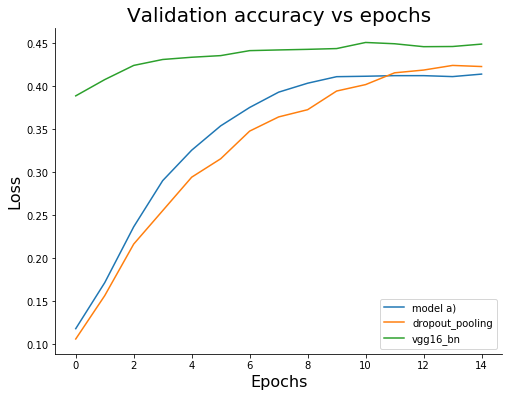

In [94]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)


#plt.plot(val_loss_b1,label='accuracy')
plt.plot(val_acc,label='model a)')
plt.plot(val_acc_b4,label='dropout_pooling')
plt.plot(val_acc_d,label='vgg16_bn')

plt.title('Validation accuracy vs epochs', fontsize=20)

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.legend()
#plt.ylim(0,1.0)
plt.show()

Se observa claramente que el problema de underfitting del modelo se soluciona, obteniéndose rápidamente mejores resultados que en los dos enfoques anteriores. El hecho de haber solucionado el problema del covariate shift permite un entrenamiento más rápido del modelo, tal y como indican los autores del paper original, ya que cada vez que se actualizan los pesos de la red, las distribuciones no cambian fundamentalmente como para llegar a deshacer lo aprendido por las capas superiores.

En cuanto a tiempos de computación, utilizar Batch Normalization claramente conlleva un incremento, ya que en cada paso se debe computar la media y la desviación estándar del batch y aplicar la normalización. Sin embargo, vemos que al aplicar Batch Normalization se necesita una menor cantidad de epochs que utilizando otras técnicas, como dropout, por lo que el costo computacional asociado termina siendo un trade-off deseable. Además, como vamos a ver a continuación, el incremento no es significativo (en este caso) si se está entrenando con GPU.

### Tiempos computacionales con y sin Batch Normalization
El siguiente es el tiempo necesario para realizar un epoch del entrenamiento del modelo sin batch normalization:

![title](part2code/tiempo_nbn.png)

a continuación, se presenta el tiempo utilizando batch normalization:

![title](part2code/tiempo_bn.png)

Se observa que en cada step hay una diferencia de aproximadamente de un 50%, demorándose aproximadamente 32ms sin batch normalization y 46ms con batch normalization, lo cual, para la cantidad de epochs que realizamos, no es una diferencia significativa.




f) Finalmente experimente con utilizar toda la red pre-entrenada, eliminando la capa de clasificación de mil neuronas de VGG reemplazandola por la capa de clasificación para su modelo (o con alguna capa extra si estima conveniente), dejando "congelada" toda la red para atrás, ésto quiere decir que utilizará la representación generada por la última capa (no de clasificación) de la red VGG, ésto es las capas densas, no la convolucional como en la parte c). Grafique las curvas de entrenamiento (función de pérdida/loss) , comparando con b) y e).



In [108]:
#np.repeat(r[:10,i,i],7,axis=0)
np.repeat(np.repeat(r[:10,i,i].reshape(10,1),7,axis=1),7,axis=1).

(10, 49)

In [97]:
x_train.shape
new_data = np.zeros((50000,32,32,3))
for i in range(2):
    
    r = x_train[:10,:,:,0]
    g = x_train[:10,:,:,1]
    b = x_train[:10,:,:,2]
    
    print(r.shape)
    r2 = np.repeat(np.repeat(r[:10,i,i],7,axis=0),7,axis=1)
    print(r2[:10,i,i].shape)
    #x = x.reshape((-1,7,7))
    #print(x_train[0,:])
    print(x.shape)
    print(x)
    #new_data[:,i*7:(i+1)*7,i*7:(i+1)*7] = 

(10, 32, 32)


AxisError: axis 1 is out of bounds for array of dimension 1

## g)
¿Cuándo podría ser útil y cuando no utilizar transfer learning o una red pre-entrenada?

Transfer learning podría ser útil cuando se tienen pocos datos del dominio en particular y cuando la naturaleza del dominio fuente es similar a la del dominio objetivo. En este caso, por ejemplo, tanto el dataset CIFAR-100 como ImageNet consisten de imágenes de entidades del mundo real, por lo que existen características comunes a este tipo de imágenes que pueden ser transferidades de un dominio a otro. En particular, en problemas de clasificación de entidades en imágenes, las características básicas que deben ser extraidas son similares en diversos dominios (lineas, esquinas, ciertos patrones geométricos, etc), por lo que el transferir estas características, tal como se observó en esta pregunta, es de gran ayuda para mejorar la capacidad de los modelos. Además, es conveniente usar una red pre-entrenada si la capacidad computacional no es suficiente como para entrenar una red con millones de parámetros. En este caso, por ejemplo, no se podría haber cargado la red completamente e reiniciar su entrenamiento, por lo que simplemente se obtuvieron las activaciones generadas por el modelo y se construyó uno a partir de éstas.

Creemos que no sería útil utilizar transfer learning cuando los dominios no son similares: eg. imagénes versus audio, en lo que las características aprendidas en un dominio serían inútiles para el otro. Además, si se tienen suficientes datos de entrenamiento del dominio específico y la capacidad computacional como para entrenar un modelo con una gran cantidad de parámetros, entonces transfer learning podría ser inútil, ya que se podrían extraer las características particular importantes del dominio objetivo sin la necesidad de transferir características que podrían ocasionar ruido e inducir negative transfer; el fenómeno cuando el transfer learning induce un empeoramiento en el desempeño de los algoritmos. 